In [20]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re
import emoji
from string import punctuation
from collections import Counter
from nltk import word_tokenize

# Define the URL
url = "https://raw.githubusercontent.com/jvo024/ads509-movie-scrape/main/datasets/all_tmbd_rt_data.csv"

# Read data from the URL into a DataFrame
df = pd.read_csv(url)

# Display the first few rows of the DataFrame (optional)
df.head()

,movie_title,review_rating,review_content,sentiment
0,Blue Beetle,7.0,MORE SPOILER-FREE MINI-REVIEWS @ https://www.m...,good
1,Blue Beetle,6.0,"Maybe this should just have been called the ""B...",good
2,Blue Beetle,7.0,Blue beetle is very awesome!! WoW!👏🏻👏🏻👍🏻👍🏻,good
3,Blue Beetle,6.0,The Good: Light-hearted and family centric. Lo...,good
4,Meg 2: The Trench,5.0,"Now the ""Meg"" (2018) itself could never be cal...",good


In [35]:
def descriptive_stats(tokens, top_tokens = 10, verbose=True) :

    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = num_unique_tokens / num_tokens
    num_characters = sum(len(token) for token in tokens)
    token_counter = Counter(tokens)
    most_common_tokens = token_counter.most_common(top_tokens)

    if verbose:
        print(f"Number of tokens: {num_tokens}")
        print(f"Number of unique tokens: {num_unique_tokens}")
        print(f"Number of characters: {num_characters}")
        print(f"Lexical diversity: {lexical_diversity:.3f}")
        # 5 most common tokens
        print(f"Most common tokens (Top {top_tokens}):")
        for token, count in most_common_tokens:
            print(f" - {token}: {count}")

    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])

punctuation = set(punctuation)

sw = stopwords.words("english")

whitespace_pattern = re.compile(r"\s+")

all_language_emojis = set()

for country in emoji.EMOJI_DATA :
    for em in emoji.EMOJI_DATA[country] :
        all_language_emojis.add(em)

def remove_stop(tokens) :
    removed_tokens = [token for token in tokens if token.lower() not in sw and token != 'nan']
    return(removed_tokens)

def remove_punctuation(text, punct_set=punctuation) :
    if text == 'nan':
        return ''  # Remove 'nan'
    return "".join([ch for ch in text if ch not in punct_set])

def tokenize(text):
    return word_tokenize(text)

def prepare(text, pipeline) :
    tokens = str(text)
    for transform in pipeline :
        tokens = transform(tokens)
    return tokens

In [22]:
pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

df["tokens"] = df["review_content"].apply(prepare, pipeline=pipeline)
df["num_tokens"] = df["tokens"].map(len)
df.head()

,movie_title,review_rating,review_content,sentiment,tokens,num_tokens
0,Blue Beetle,7.0,MORE SPOILER-FREE MINI-REVIEWS @ https://www.m...,good,"[spoilerfree, minireviews, httpswwwmsbreviewsc...",83
1,Blue Beetle,6.0,"Maybe this should just have been called the ""B...",good,"[maybe, called, blue, bottle, annoying, blowfl...",185
2,Blue Beetle,7.0,Blue beetle is very awesome!! WoW!👏🏻👏🏻👍🏻👍🏻,good,"[blue, beetle, awesome, wow👏🏻👏🏻👍🏻👍🏻]",4
3,Blue Beetle,6.0,The Good: Light-hearted and family centric. Lo...,good,"[good, lighthearted, family, centric, love, st...",24
4,Meg 2: The Trench,5.0,"Now the ""Meg"" (2018) itself could never be cal...",good,"[meg, 2018, could, never, called, good, film, ...",215


In [23]:
good_df = df[df['sentiment'] == 'good']
bad_df = df[df['sentiment'] == 'bad']

# combine tokens
good_tokens = good_df["tokens"].sum()
bad_tokens = bad_df["tokens"].sum()

In [36]:
print(f"-- Good Reviews --")
good_stats = descriptive_stats(good_tokens)
print(f"-- Bad Reviews --")
bad_stats = descriptive_stats(bad_tokens)

-- Good Reviews --
Number of tokens: 882412
Number of unique tokens: 50714
Number of characters: 5357090
Lexical diversity: 0.057
Most common tokens (Top 10):
 - film: 10464
 - movie: 8814
 - ’: 7549
 - one: 6790
 - like: 4857
 - story: 4770
 - good: 4330
 - well: 3836
 - really: 3708
 - time: 3544
-- Bad Reviews --
Number of tokens: 133624
Number of unique tokens: 18639
Number of characters: 800895
Lexical diversity: 0.139
Most common tokens (Top 10):
 - movie: 1830
 - film: 1563
 - ’: 1427
 - one: 1046
 - like: 1030
 - even: 745
 - good: 695
 - really: 606
 - story: 565
 - much: 546


In [29]:
from collections import Counter

total_good = good_stats[0]
total_bad = bad_stats[0]

token_counts_good = Counter(good_tokens)
token_counts_bad = Counter(bad_tokens)

good_df = pd.DataFrame(token_counts_good.items(), columns=["token", "good_tokens"])
bad_df = pd.DataFrame(token_counts_bad.items(), columns=["token", "bad_tokens"])

# Calculate the concentration for good_tokens
good_df["good concentration"] = good_df.apply(lambda row: row["good_tokens"] / total_good, axis=1)

# Calculate the concentration for bad_tokens
bad_df["bad concentration"] = bad_df.apply(lambda row: row["bad_tokens"] / total_bad, axis=1)

df = [good_df, bad_df]

group_df = df[0]
for df in df[1:]:
    group_df = pd.merge(group_df, df, on="token", how="inner")

cutoff = 10

def check_cutoff(column):
    return (column['good_tokens'] + column['bad_tokens']) > cutoff

# Apply the custom function to create the new column
group_df['cutoff'] = group_df.apply(check_cutoff, axis=1)

group_df['ratio'] = (group_df["good concentration"])/(group_df["bad concentration"])
sorted_group = group_df.sort_values(by="ratio", ascending=False)
top_group = sorted_group.head(10)
top_group

,token,good_tokens,good concentration,bad_tokens,bad concentration,cutoff,ratio
5549,810,163,0.000185,1,0.000007,True,24.683155
3494,wonderfully,134,0.000152,1,0.000007,True,20.291673
3919,1010,94,0.000107,1,0.000007,True,14.234457
138,denouement,87,0.000099,1,0.000007,True,13.174445
2860,ups,76,0.000086,1,0.000007,True,11.508710
5739,treasure,75,0.000085,1,0.000007,True,11.357280
2837,elevates,73,0.000083,1,0.000007,True,11.054419
4056,mindblowing,72,0.000082,1,0.000007,True,10.902989
8942,woods,71,0.000080,1,0.000007,True,10.751558
7298,2008,70,0.000079,1,0.000007,True,10.600128


In [32]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400,
                   background_color= "black", colormap="Paired",
                   max_font_size=150, max_words=max_words)

    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items()
                   if token not in stopwords}
    wc.generate_from_frequencies(counter)

    plt.title(title)

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")


def count_words(df, column='token', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'

    return freq_df.sort_values('freq', ascending=False)

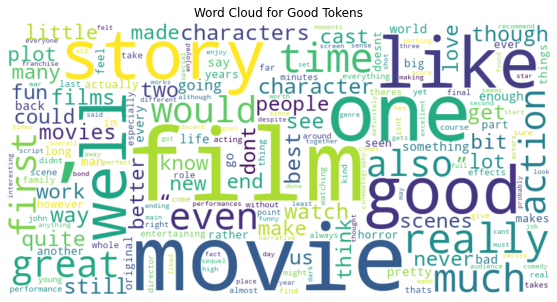

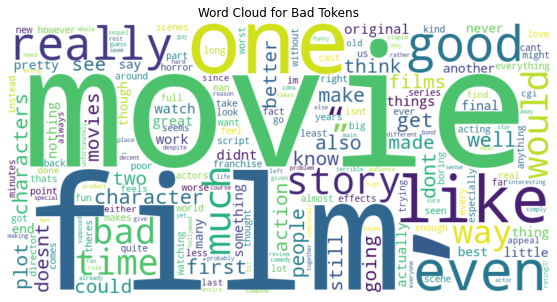

In [34]:
def generate_wordcloud(tokens, title):
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(tokens)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

# Create word clouds for good_tokens and bad_tokens
good_word_counts = Counter(good_tokens)
bad_word_counts = Counter(bad_tokens)

generate_wordcloud(good_word_counts, "Word Cloud for Good Tokens")
generate_wordcloud(bad_word_counts, "Word Cloud for Bad Tokens")